# FT-transformer regression sample by pytorch-tabular

### Import libraries

In [1]:
!pip install pytorch-tabular

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from scipy.stats import loguniform
from tqdm import tqdm
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence

from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models import FTTransformerConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

In [3]:
# Avoid occuring error in model training
import torch
import omegaconf
import typing
import collections
torch.serialization.add_safe_globals([omegaconf.dictconfig.DictConfig])
torch.serialization.add_safe_globals([omegaconf.base.ContainerMetadata])
torch.serialization.add_safe_globals([omegaconf.listconfig.ListConfig])
torch.serialization.add_safe_globals([omegaconf.nodes.AnyNode])
torch.serialization.add_safe_globals([omegaconf.base.Metadata])
torch.serialization.add_safe_globals([typing.Any])
torch.serialization.add_safe_globals([dict])
torch.serialization.add_safe_globals([list])
torch.serialization.add_safe_globals([int])
torch.serialization.add_safe_globals([collections.defaultdict])

### Dataset

In [4]:
# ----------------------------------------------
# Create sample dataset
# ----------------------------------------------

# Dataset
housing = fetch_california_housing()
housing_data = pd.DataFrame(data = housing.data, columns = housing.feature_names)
housing_data['target'] = housing.target
housing_data.reset_index(inplace = True, drop = True)

# Functions
def make_correlation_category(
        x_grid: list,
        y_grid: list,
        x_feature_name: str,
        y_feature_name: str,
        datset: pd.core.frame.DataFrame,
        catefory_names = list('ABCDEFGHIJKLMNOPQLSTUVWXYZ')
):
    i = 0
    index_list = []
    category_list = []
    for y1, y2 in zip(y_grid[:-1], y_grid[1:]):
        for x1, x2 in zip(x_grid[:-1], x_grid[1:]):
            temp_data = datset[(x1<=datset[x_feature_name]) & (datset[x_feature_name]<x2) & (y1<=datset[y_feature_name]) & (datset[y_feature_name]<y2)].copy()
            if temp_data.shape[0] > 0:
                index_list += temp_data.index.tolist()
                category_list += [catefory_names[i] for k in range(temp_data.shape[0])]
                i += 1
    return np.array(category_list)[np.argsort(np.array(index_list))]

# Make categorical features 1
housing_data['Area_category'] = make_correlation_category(
    x_grid = [32, 34, 36, 38, 40, 44],
    y_grid = [-126, -122, -120, -118, -116, -114],
    x_feature_name = 'Latitude',
    y_feature_name = 'Longitude',
    datset = housing_data,
)

# Make categorical features 2
housing_data['Room_num_category'] = make_correlation_category(
    x_grid = [0, 5, 10, 40],
    y_grid = [0, 20, 40, 170],
    x_feature_name = 'AveBedrms',
    y_feature_name = 'AveRooms',
    datset = housing_data,
)

In [5]:
housing_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,Area_category,Room_num_category
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,A,A
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,A,A
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,A,A
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,A,A
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,A,A
...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,F,A
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,F,A
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,F,A
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,F,A


### Train-test split

In [6]:
train_valid_data, test_data = train_test_split(housing_data, test_size=0.2, shuffle=True)
print(f'Train & validation data shape: {train_valid_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train & validation data shape: (16512, 11)
Test data shape: (4128, 11)


### Category encoding

In [7]:
# ----------------------------------------------
# Categorical encoding
# ----------------------------------------------

categorical_featues = ['Area_category', 'Room_num_category']
categorical_encoders = {}
for col in categorical_featues:
    enc = LabelEncoder()
    enc.fit(train_valid_data[col].unique())
    train_valid_data[col+'_encoded'] = enc.transform(train_valid_data[col])
    categorical_encoders[col] = enc

### Common config

In [12]:
# Variable names
target_name = ['target']
numerical_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
categorical_names = ['Area_category_encoded', 'Room_num_category_encoded']

# Data config
data_config = DataConfig(
    target=target_name,
    continuous_cols=numerical_names,
    categorical_cols=categorical_names,
)

# Trainer config
trainer_config = TrainerConfig(
    batch_size=256,
    max_epochs=10, # small epoch for sample code
    early_stopping="valid_loss",
    early_stopping_mode="min",
    early_stopping_patience=5,
    checkpoints="valid_loss",
    load_best=True,
)

# Optimizer config
optimizer_config = OptimizerConfig()

# Head config
head_config = LinearHeadConfig(
    layers="",
    dropout=0.1,
    initialization="kaiming",
).__dict__

### Training

In [13]:
# Model config
model_config = FTTransformerConfig(
    task="regression",
    learning_rate=1e-3,
    head="LinearHead",
    head_config=head_config,
)

# Model define
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

# Training
tabular_model.fit(train=train_valid_data)

INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for regression task
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71:

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ FTTransformerBackbone │  271 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer      │  1.4 K │ train │
│ 2 │ _head            │ LinearHead            │     33 │ train │
│ 3 │ loss             │ MSELoss               │      0 │ train │
└───┴──────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 272 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 272 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 126                                                                                         
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is 
set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model


### Evaluation

In [14]:
# ----------------------------------------------
# Categoty encoding of test dataset
# ----------------------------------------------
for col, enc in categorical_encoders.items():
    test_data[col+'_encoded'] = enc.transform(test_data[col])

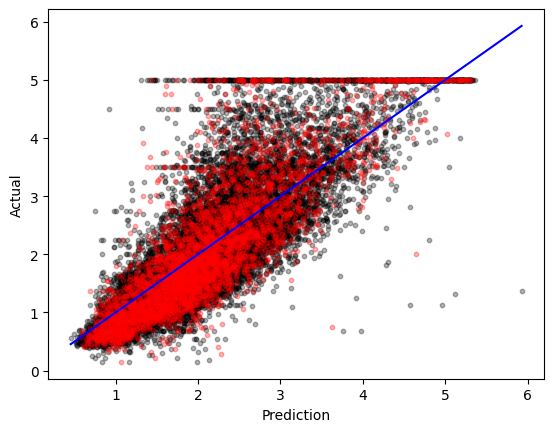

Train RMSE: 0.40948
Test RMSE: 0.39520


In [61]:
# ----------------------------------------------
# Model evaluation by test data
# ----------------------------------------------

# Prediction (train)
y_pred_train = tabular_model.predict(train_valid_data)

# Prediction (Test)
y_pred_test = tabular_model.predict(test_data)

# Plot
plt.scatter(y_pred_train.values.ravel(), train_valid_data[target_name].values.ravel(), s=10, color='k', alpha=0.3)
plt.scatter(y_pred_test.values.ravel(), test_data[target_name].values.ravel(), s=10, color='r', alpha=0.3)
plt.plot([y_pred_train.min(), y_pred_train.max()], [y_pred_train.min(), y_pred_train.max()], color='b')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

# Metrics
RMSE_train = mean_squared_error(y_true = train_valid_data[target_name].values.ravel(), y_pred = y_pred_train)
RMSE_test = mean_squared_error(y_true = test_data[target_name].values.ravel(), y_pred = y_pred_test)
print(f'Train RMSE: {RMSE_train:.5f}')
print(f'Test RMSE: {RMSE_test:.5f}')

### Permutation importance

In [36]:
# Calculate importance
import warnings
warnings.simplefilter('ignore', FutureWarning)

scorer = make_scorer(r2_score)
importance = permutation_importance(
    tabular_model,
    train_valid_data[numerical_names+categorical_names],
    train_valid_data[target_name],
    scoring=scorer,
    n_repeats=5
)
importance_data = pd.DataFrame(importance['importances_mean'], columns=['importances_mean'], index=numerical_names+categorical_names).sort_values('importances_mean')

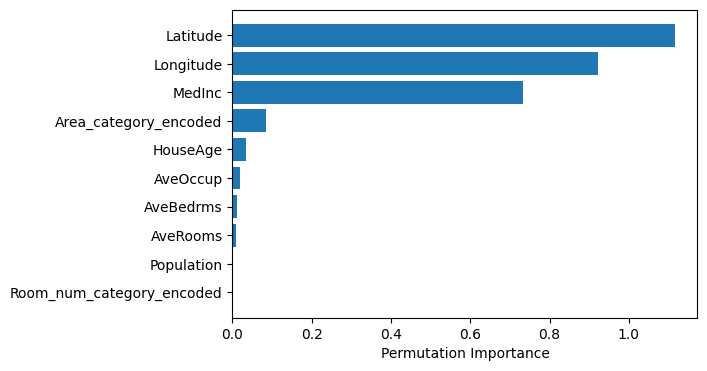

In [52]:
# Plot
plt.figure(figsize=(6, 4))
plt.barh(importance_data.index, importance_data['importances_mean'])
plt.xlabel('Permutation Importance')
plt.show()

### Partial dependence plot

In [25]:
tabular_model

Layer,Type,Params,In sizes,Out sizes
_backbone,FTTransformerBackbone,271344,?,?
_embedding_layer,Embedding2dLayer,1376,?,?
_head,LinearHead,33,?,?
loss,MSELoss,0,?,?


In [30]:
train_valid_data[numerical_names+categorical_names]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Area_category_encoded,Room_num_category_encoded
15554,2.2146,31.0,3.956803,0.958963,1669.0,3.604752,33.11,-117.08,11,0
18778,2.8611,17.0,5.832653,1.081633,692.0,2.824490,40.42,-122.25,2,0
15452,5.5956,4.0,7.298377,1.116105,2282.0,2.848939,33.16,-117.31,11,0
2178,2.8750,34.0,5.218354,1.022152,919.0,2.908228,36.76,-119.87,9,0
19151,1.6033,14.0,4.641791,1.101493,493.0,1.471642,38.35,-122.70,1,0
...,...,...,...,...,...,...,...,...,...,...
2013,2.4167,43.0,4.733333,1.080000,233.0,3.106667,36.71,-119.83,9,0
15543,8.5957,8.0,8.105882,1.008824,1045.0,3.073529,33.07,-117.07,11,0
19615,2.8558,31.0,4.991837,1.346939,1067.0,4.355102,37.56,-121.27,4,0
7175,2.4375,47.0,4.896154,1.015385,1193.0,4.588462,34.05,-118.19,8,0
